In [13]:
import qrcode
qr = qrcode.QRCode(
    version=1,
    box_size=2,
    border=0
)

qr.add_data(0)
qr.make()

img = qr.make_image()
img = img.convert('RGB')
img.save('code.png')

In [1]:
import qrcode
import os 

img_dir = 'data/qrdataset/pics/'
num = 8192
for i in range(num):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=2,
        border=0
    )
    qr.add_data(str(i))
    qr.make()
    img = qr.make_image()
    img = img.convert('RGB')

    img_path = os.path.join(img_dir, str(i+1) + '.png')
    img.save(img_path)

In [2]:
import os 
import random

img_dir = 'data/qrdataset/pics/'
index_file = 'data/qrdataset/index.txt'
#index_file = 'data/qrdataset/attack.txt'

with open(index_file, 'w') as f:
    img_name = os.listdir(img_dir)
    for path in img_name:
        img_path = os.path.join(img_dir, path)
        label = random.randint(0, 1)
        f.write(img_path + ' ' + str(label) + '\n')

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import ResNet18
from utils import *
from watermark import MTLSign, QRset


'''Device setting'''
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'


'''Train/test dataloader setting'''
print("Using CIFAR10 dataset.")
test_db_path = './data'
batchsize = 100
num_classes = 10

transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

testset = torchvision.datasets.CIFAR10(root=test_db_path,train=False, download=True,
                                        transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                            shuffle=False, num_workers=4)


'''QRdataset setting'''
qr_transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])
wmset = QRset('./data/qrdataset/index.txt', transform=qr_transform)
wmloader = torch.utils.data.DataLoader(
    dataset=wmset,
    batch_size=100,
    shuffle=True
)


'''Load pretrained model'''
wmend_path = './checkpoint/wm_4000_model.pth'
model_path = './checkpoint/resnet18_50.pth'
wm_ckp = torch.load(wmend_path)
model_ckp = torch.load(model_path)
model = ResNet18().to(device)
model.load_state_dict(model_ckp['model_state_dict'])
MTL = MTLSign()
MTL.wmend.load_state_dict(wm_ckp['wm_bacend'])
criterion = nn.CrossEntropyLoss()

'''Model test'''
print("\nTest pretrained model...")    
test(model, criterion, testloader, device)

print("Test wm embedding acc...")
MTL.wmend.eval()
wm_correct = 0
wm_total = 0
for idx, (wm_inputs, wm_targets) in enumerate(wmloader):
    wm_inputs, wm_targets = wm_inputs.to(device), wm_targets.to(device)

    wm_outputs = MTL.verify(model, wm_inputs, device)
    _, predicts = torch.max(wm_outputs.data, 1)
    wm_total += wm_targets.size(0)
    wm_correct += predicts.eq(wm_targets.data).cpu().sum()

print("wm acc: %.3f%% (%d / %d)"
        % (100. * wm_correct / wm_total, wm_correct, wm_total))

Using CIFAR10 dataset.
Files already downloaded and verified

Test pretrained model...
[Test] Loss: 0.296 | Acc: 92.060% (9206 / 10000)
Test wm embedding acc...
wm acc: 57.450% (2298 / 4000)


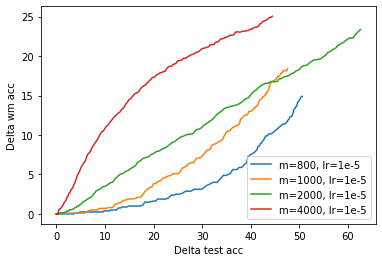

In [2]:
import matplotlib.pyplot as plt

f400 = './log/wm_num_400_id_9/attack_epoch_200_lr_1e-05.txt'
f800 = './log/wm_num_800_id_8/attack_epoch_200_lr_1e-05.txt'
f1000 = './log/wm_num_1000_id_6/attack_epoch_200_lr_1e-05.txt'
f2000 = './log/wm_num_2000_id_7/attack_epoch_200_lr_1e-05.txt'
f4000 = './log/wm_num_4000_id_3/attack_epoch_200_lr_1e-05.txt'
file = [f400, f800, f1000, f2000, f4000]
X = []
Y = []
for i in range(5):
    x = []
    y = []
    X.append(x)
    Y.append(y)

for i in range(5):
    w1 = []
    w2 = []
    w3 = []
    with open(file[i], 'r') as f:
        for line in f:
            words = line.split()
            w1.append(int(words[0]))
            w2.append(float(words[1]))
            w3.append(float(words[2]))

    testacc = w2[0]
    wmacc = w3[0]

    X[i] = [testacc - i for i in w2]
    Y[i] = [wmacc - i for i in w3]

#plt.plot(X[0], Y[0],label='m=400, lr=1e-5')
plt.plot(X[1], Y[1],label='m=800, lr=1e-5')
plt.plot(X[2], Y[2],label='m=1000, lr=1e-5')
plt.plot(X[3], Y[3],label='m=2000, lr=1e-5')
plt.plot(X[4], Y[4],label='m=4000, lr=1e-5')

plt.xlabel("Delta test acc")
plt.ylabel("Delta wm acc")
plt.legend()

save_path = 'accBER.png'
plt.savefig(save_path)
plt.show()